Kaggle Dataset Link - https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## ***Pseudo Code***

i used an LSTM architecture to implement RNN on the given dataset.

**Preprocessing**
i converted the dataset into a list of tuples of form (sentiment label,review) and on that ,i used torchtext.vocab.build_vocab_from_iterator to create my vocabulary of words taking help from yield_tokens() fn inside which i used torchtext.data.utils.get_tokenizer to tokenize my training data.
* i kept the min freq of occurance of words to be *45* which gave me a vocabulary size of *10453* ,furthur increasing vocab size led to decrease in test loss and overfitting.

**Data Transformation**

i used PyTorch torchtext.transforms functionality to make the following changes to the raw text at the time of training:

* VocabTransform -converts sentances to indices of vocab
* AddToken - To add `<sos>`  and `<eos>` to indicate start end of sentance using tokens
* Truncate -To fix a maximum length of each sentance (*250* words)
* ToTensor - converts the above to PyTorch tensors
* PadTransform - To add a padding of zeros at end of a sentance if  its length is smaller than max_length so that all sentances are of same length

Converted data into batchwise iterable DataLoader using torch.utils.data.DataLoader

**LSTMModelV0** 

This model architecture consists of of `embedding layer` -> `LSTM layer` -> `Dropout Layer`(for reducing overfitting)
Upon training with the following Hyperparameters i got a Test Accuracy close to ***88.5%***

* embedding dimention - *176*
* Hidden size - *128*
* Epochs - 8  Upon increasing the epochs model starts to overfit ,so i stopped early at 8
* lr - 0.00045 
* Regularization factor - 0.00001

Experimenting by varying lr,regularization,max_length for truncation didn't give better results than the following.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import torch
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as transform
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tqdm.auto as tqdm 
import pickle
import csv

In [3]:
df=pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['review'][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

### Pre Processing:

In [5]:
tokenizer=get_tokenizer("basic_english")

In [6]:
data=[(1 if label=="positive" else 0,x) for label,x in zip(df.sentiment,df.review)]

In [7]:
## Train Test split (80:20)
train_split=int(0.8*len(data))
train_data=data[:train_split]
test_data=data[train_split:]

In [8]:
def yield_tokens(data_iter): #generator fn
    for _,text in data_iter:
        yield tokenizer(text) 

## Building vocabulary using torchtext.vocab.build_vocab_from_iterator

In [9]:
# build_vocab_from_iterator Builds a vocabulary from the tokens yielded by the yield_tokens generator fn
vocab=build_vocab_from_iterator(yield_tokens(train_data),
                                min_freq=45,
                                specials=['<pad>','<sos>','<eos>','<unk>'],
                               special_first=True)
vocab.set_default_index(vocab["<unk>"])

In [10]:
len(vocab)

10453

In [11]:
vocab(['he','jumped' ,'over','my','car','qwerty'])

[33, 5111, 142, 65, 519, 3]

In [12]:
# vocab.get_stoi()

## Data Transformation

In [13]:
max_length=250

In [14]:
data_transform=transform.Sequential(
    # sentances -> indices of vocabulary
    transform.VocabTransform(vocab=vocab),
    
    #add <sos>(index 1 in vocab) token at beginning of each sentance 
    transform.AddToken(1,begin=True),
   
    #clip the sentance if longer than max_length
    transform.Truncate(max_seq_len=max_length-2),
    
    # add <eos> (index 2 in vocab) token at the end of each sentance
    transform.AddToken(2,begin=False),
    
    #list -> tensor, pad a sentance with <pad> token(index 0) if sentance shorter than max_length
    transform.ToTensor(padding_value=0,dtype=torch.int32),
    transform.PadTransform(max_length=max_length,pad_value=0)
    )

#Tokenizer function applied batchwise
text_tokenizer=lambda x_batch :[tokenizer(x) for x in x_batch]

In [15]:
BATCH_SIZE=32

In [16]:
def accuracy_fn(y_true,y_pred):
    correct=sum(y_true==y_pred)
    accuracy=correct/len(y_pred)*100
    return accuracy


In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_dataloader=DataLoader(dataset=train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78db1426eb30>,
 <torch.utils.data.dataloader.DataLoader at 0x78db0fc66470>)

In [18]:
len(train_data)

40000

In [19]:
label,text=next(iter(train_dataloader))
data_transform(text_tokenizer(text)).shape
#(batch_size,max_length)

torch.Size([32, 250])

In [20]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
class LSTMModelV0(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_size,num_layers,output_size,bidirectionality):
        super().__init__()
        
        self.embedding_layer=nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=embedding_dim)
        self.lstm=nn.LSTM(input_size=embedding_dim,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=bidirectionality)
        self.dropout=nn.Dropout(p=0.5)
        if bidirectionality==True:
            self.fcl = nn.Linear(in_features=hidden_size * 2, out_features=output_size)
        else:
            self.fcl = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self,x):
        embedding=self.embedding_layer(x)
        out,_=self.lstm(embedding)# returns all the hidden states
        out=self.dropout(out)
        return self.fcl(out[:,-1,:]) # indexing done to extract the (hidden state)/output of the last time step alone (many-to-one architecture)
        

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0=LSTMModelV0(vocab_size=len(vocab),
                   embedding_dim=176,
                   hidden_size=128,
                   num_layers=1,
                   output_size=1,
                   bidirectionality=False).to(device)


In [23]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.00045,
                             weight_decay=1e-5)


In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]
epochs=8
for epoch in range(epochs):
    print(f"Epoch:{epoch} -----------------------------------------------------------------")
    model_0.train()
    train_loss,test_loss=0,0
    train_accuracy,test_accuracy=0,0
    test_loss
    for labels,text in train_dataloader:
        labels=labels.to(device)
        text_tokens=data_transform(text_tokenizer(text)).to(device)
        y_logits=model_0(text_tokens)
        y_pred=torch.round(torch.sigmoid(y_logits.squeeze()))
        train_accuracy+=accuracy_fn(y_true=labels,
                                y_pred=y_pred)
        loss=loss_fn(y_logits.squeeze(),labels.float())
        
        train_loss+=loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    train_loss/=len(train_dataloader)
    train_accuracy/=len(train_dataloader)
    train_losses.append(train_loss.item())
    train_acc.append(train_accuracy.item())

    
    model_0.eval()
    with torch.inference_mode():
        for test_labels,test_text in test_dataloader:
            test_labels=test_labels.to(device)
            test_text_tokens=data_transform(text_tokenizer(test_text)).to(device)

            test_logits=model_0(test_text_tokens)
            test_pred=torch.round(torch.sigmoid(test_logits.squeeze()))

            test_loss+=loss_fn(test_pred,test_labels.float())
            test_accuracy+=accuracy_fn(y_true=test_labels,
                                      y_pred=torch.round(torch.sigmoid(test_logits.squeeze())))
        
        test_loss/=len(test_dataloader)
        test_accuracy/=len(test_dataloader)
        test_losses.append(test_loss.item())
        test_acc.append(test_accuracy.item())

    
        print(f"Train Loss:{train_loss:.4f} | Train Accuracy:{train_accuracy:.2f}% | Test Loss:{test_loss:.4f} | Test Accuracy:{test_accuracy:.2f}%\n")
        
        
    
        

Epoch:0 -----------------------------------------------------------------
Train Loss:0.6946 | Train Accuracy:50.46% | Test Loss:0.7872 | Test Accuracy:52.04%

Epoch:1 -----------------------------------------------------------------
Train Loss:0.6929 | Train Accuracy:51.12% | Test Loss:0.7411 | Test Accuracy:51.39%

Epoch:2 -----------------------------------------------------------------
Train Loss:0.6900 | Train Accuracy:52.79% | Test Loss:0.7335 | Test Accuracy:53.98%

Epoch:3 -----------------------------------------------------------------
Train Loss:0.6718 | Train Accuracy:58.19% | Test Loss:0.7297 | Test Accuracy:57.81%

Epoch:4 -----------------------------------------------------------------
Train Loss:0.6769 | Train Accuracy:58.22% | Test Loss:0.6934 | Test Accuracy:66.38%

Epoch:5 -----------------------------------------------------------------
Train Loss:0.4952 | Train Accuracy:76.59% | Test Loss:0.5786 | Test Accuracy:85.66%

Epoch:6 --------------------------------------

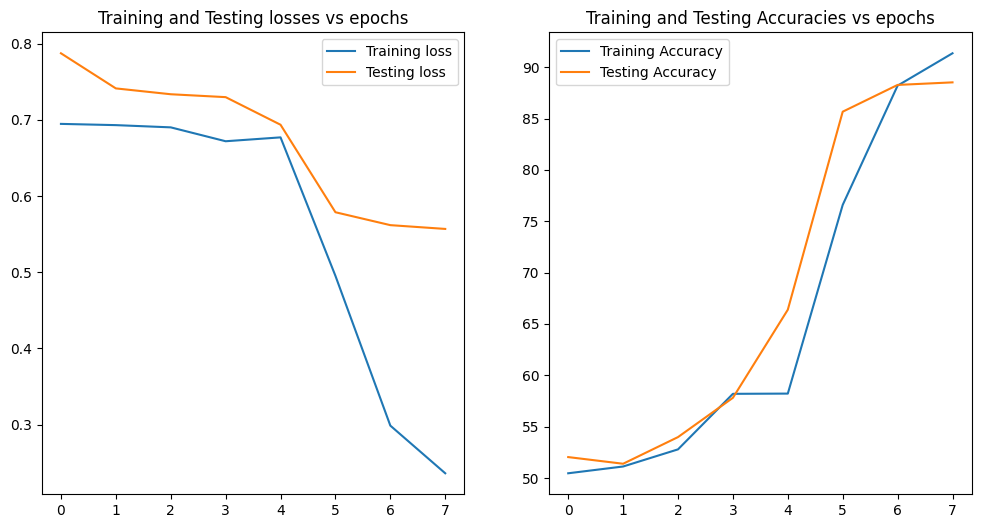

In [25]:
x=[i for i in range(8)]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x,train_losses,label="Training loss")
plt.plot(x,test_losses,label="Testing loss")
plt.legend()
plt.title("Training and Testing losses vs epochs")

plt.subplot(1,2,2)
plt.plot(x,train_acc,label="Training Accuracy")
plt.plot(x,test_acc,label="Testing Accuracy")
plt.title("Training and Testing Accuracies vs epochs")
plt.legend()
plt.show()

In [26]:
torch.cuda.empty_cache()

### Inference

In [27]:
pred_labels=[]
model_0.eval()
with torch.inference_mode():
    test_dataloader=DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
    test_accuracy,test_loss=0,0
    for test_labels,test_text in test_dataloader:
            test_labels=test_labels.to(device)
            test_text_tokens=data_transform(text_tokenizer(test_text)).to(device)

            test_logits=model_0(test_text_tokens)
            test_pred=torch.round(torch.sigmoid(test_logits.squeeze()))
            pred_labels.extend(test_pred)
            test_loss+=loss_fn(test_logits.squeeze(),test_labels.float())
            test_accuracy+=accuracy_fn(y_true=test_labels,
                                      y_pred=test_pred)

    test_loss/=len(test_dataloader)
    test_accuracy/=len(test_dataloader)

    print(f"Test loss:{test_loss:.4f} | Test accuracy:{test_accuracy:.2f}%")

Test loss:0.2841 | Test accuracy:88.50%


In [28]:
pred_labels=[int(i.item()) for i in pred_labels]

## Saving model weights(state_dict)

In [29]:
model_0_state_dict=model_0.state_dict()
path_0="/kaggle/working/model_0_weights.pkl"

with open(path_0,'wb') as f:
    pickle.dump(model_0_state_dict,f)

## Saving model Predictions

In [30]:
with open("model_0_preds.csv",'w') as f:
    wobj=csv.writer(f)
    for i in pred_labels:
        wobj.writerow([i])